## Make Layerwise Relevance Propagation Maps

In [75]:
import tensorflow as tf
import keras 
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import innvestigate
tf.compat.v1.disable_eager_execution()

import matplotlib.pyplot as plt 
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from utils.read_data_utils import (
    get_input_data, 
    format_input_data
)
from utils.misc_utils import (
    get_model_settings, 
)  

%config InlineBackend.figure_format = 'retina'

## 1. Load in trained model and training data 
First, set the model_ID corresponding to the model you want to perform the analysis on. <br>Then, read in the training data and the trained model. 

In [201]:
MODEL_ID = "frances_Texas"
DATA_DIR = "../data/input_data_preprocessed/us_states/" 
MODEL_OUTPUT_DIR = "../model_output/us_states/"+MODEL_ID+"/"

In [202]:
# Get model settings for MODEL_ID 
settings = get_model_settings(MODEL_ID)

# Get formatted input data 
x_train_ds, y_train_df, x_val_ds, y_val_df, x_test_ds, y_test_df = get_input_data(DATA_DIR, settings)
x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot, x_test, y_test, y_test_onehot = format_input_data(x_train_ds, y_train_df, x_val_ds, y_val_df, x_test_ds, y_test_df)

# Combine training, validation, and testing datasets into one object 
x_ds = xr.concat(
    [x_train_ds, x_val_ds, x_test_ds], 
    dim="time"
    )
x = x_ds.to_array().transpose("time", "lat", "lon", "variable").values

# Get names of features
feature_ids = list(x_ds.data_vars)

model id: frances_Texas
model settings: {
    "model_id": "frances_Texas",
    "labels_geom": "Texas",
    "features_geom": "CONUS",
    "epochs": 500,
    "batch_size": 2048,
    "learning_rate": 0.004,
    "activity_reg": 0.001,
    "conv_filters": 16,
    "dense_neurons": 16,
    "dense_layers": 1,
    "random_seed": 333,
    "dropout_rate": 0.2
}


In [203]:
# Read in trained model
model_path = "{0}{1}_model/".format(MODEL_OUTPUT_DIR,MODEL_ID)
model =  tf.keras.models.load_model(model_path)
model.summary()

2023-12-06 15:07:45.091574: W tensorflow/c/c_api.cc:305] Operation '{name:'AssignVariableOp_232' id:8310 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_232}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](false_positives_24, Identity_232)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 33, 16)        304       
                                                                 
 activation (Activation)     (None, 13, 33, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 16, 16)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 6, 16, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 14, 16)         2320      
                                                                 
 activation_1 (Activation)   (None, 4, 14, 16)         0         
                                                        

### Get dates when EPCP is predicted 
This will be used to subset the data 

In [204]:
predictions_filepath = "{0}{1}_predictions.csv".format(MODEL_OUTPUT_DIR,MODEL_ID)
predictions = pd.read_csv(predictions_filepath, index_col=False)
dates_epcp = predictions[predictions["predicted_class"]==1]["time"].values # Days when EPCP is predicted to occur
dates_no_epcp = predictions[predictions["predicted_class"]==0]["time"].values # Days when EPCP is predicted to occur

## 3. Create the Layerwise Relevance Propagation Intepretations 
Use the package [innvestigate](https://github.com/albermax/innvestigate) to build the LRP maps 

In [205]:
# Remove the last dense layer with softmax activation
model_no_softmax = innvestigate.model_wo_softmax(model)

In [206]:
# Build the LRP analyzer 
lrp_analyzer = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlpha1Beta0(model_no_softmax)

In [207]:
# Use the analyzer 
lrp_np = lrp_analyzer.analyze(x)

2023-12-06 15:07:49.010214: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_86/Assign' id:9033 op device:{requested: '', assigned: ''} def:{{{node kernel_86/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_86, kernel_86/Initializer/stateless_random_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-06 15:07:49.275473: W tensorflow/c/c_api.cc:305] Operation '{name:'gradients_92/MaxNeuronSelection_6/Max_grad/range' id:9144 op device:{requested: '', assigned: ''} def:{{{node gradients_92/MaxNeuronSelection_6/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_6/Max"], _has_manual_control_dependencies=true](gradients_92/MaxNeuronSelection_6/Max_grad/range/start, gradients_92/MaxNeuronSelection_6/Max_grad/Size, gradients_92/Max

In [208]:
lrp_ds = xr.Dataset(
    data_vars=dict(
        {
            feature_ids[0]:(["time", "lat", "lon"], lrp_np[:,:,:,0]), 
            feature_ids[1]:(["time", "lat", "lon"], lrp_np[:,:,:,1]),
        }
    ),
    coords=x_ds.coords
)

In [209]:
def make_heatmap(da, cmap="hot_r", col="variable", levels=8): 
    """Make heatmaps

    Parameters
    ----------
    da: xr.DataArray 
        Data to plot. Must have dimensions "lat","lon" and col
    cmap: str, optional
        Colormap to use. Must correspond to a matplotlib colormap
    col: str, optional 
        Column to wrap for subplots
    levels: int, optional 
        Number of levels to use for contouring. 
        Default to 10 

    Returns 
    --------
    pl: xarray.plot.facetgrid.FacetGrid at 0x3717894b0
    
    """

    # Set map projections 
    data_crs = ccrs.PlateCarree()
    map_crs = ccrs.AlbersEqualArea(
        central_longitude=-100, 
        central_latitude=35, 
        standard_parallels=(30, 60)
        )

    # Use xarray to make subplots  
    pl = da.plot.contourf(
        x="lon", y="lat", col=col, 
        transform=data_crs,
        subplot_kws={'projection':map_crs}, 
        levels=levels,
        #extend="both",
        cbar_kwargs={"label":"relevance (unitless)", 'orientation':'horizontal', 'shrink':0.5,}, 
        cmap=cmap,
        zorder=5
        )

    # Add coastlines and state boundaries 
    for ax in pl.axs.flatten():
        ax.add_feature(cfeature.COASTLINE.with_scale('110m'), zorder=10, linewidth=0.4)
        ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=10, linewidth=0.4)
        
    return pl 

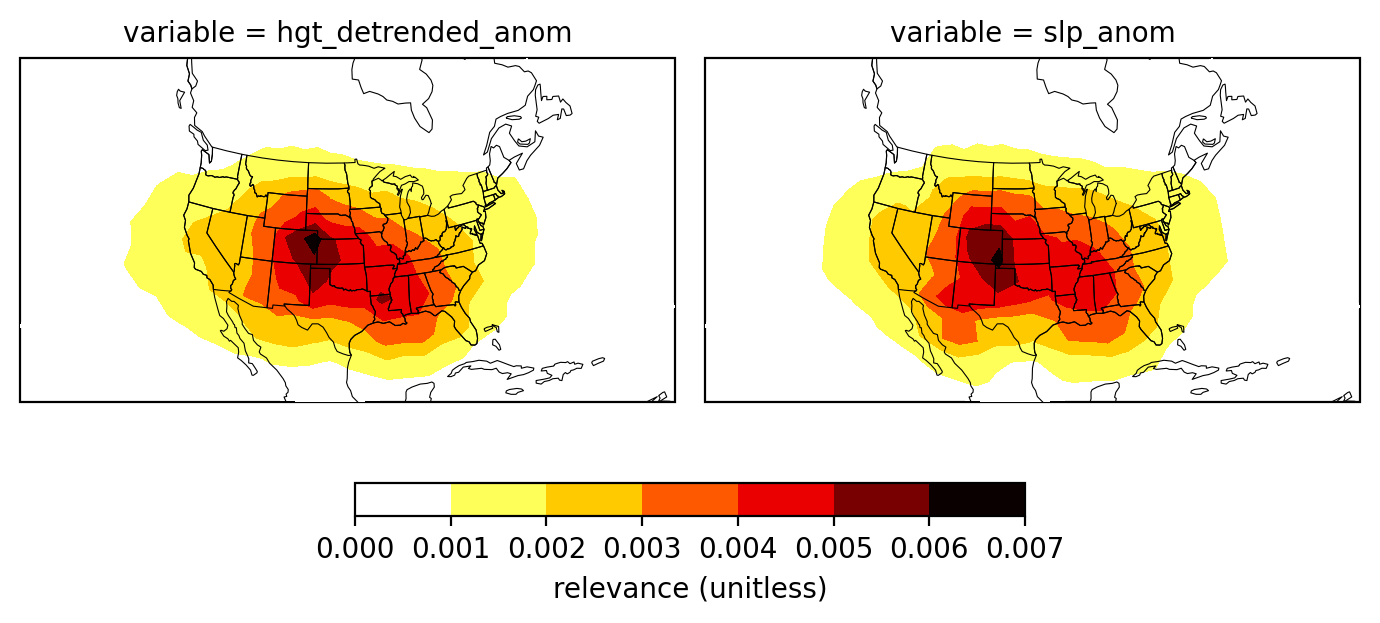

In [216]:
lrp_no_epcp = lrp_ds.sel(time=dates_no_epcp)
mean_lrp_no_epcp = lrp_no_epcp.mean(dim="time").to_array()
make_heatmap(mean_lrp_no_epcp, col="variable");

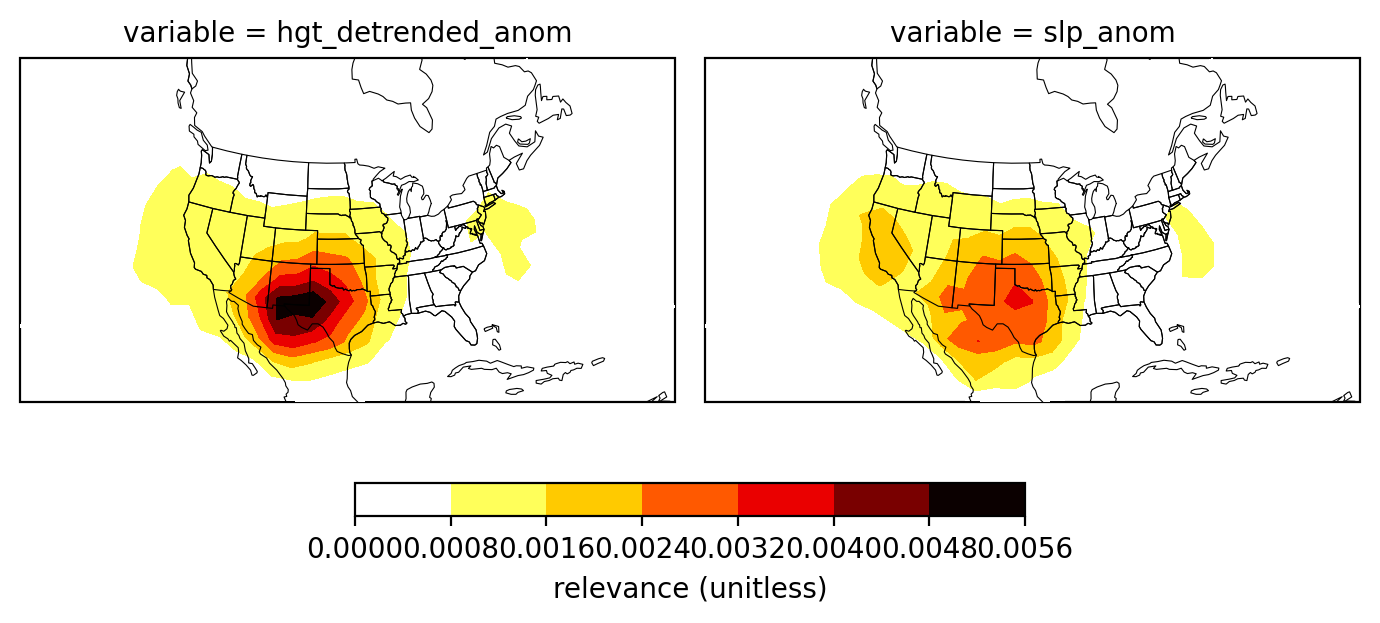

In [211]:
lrp_epcp = lrp_ds.sel(time=dates_epcp)
mean_lrp_epcp = lrp_epcp.mean(dim="time").to_array()
make_heatmap(mean_lrp_epcp, col="variable");

## Peform k-means clustering of the LRP maps 

In [212]:
def kmeans_clusters_xr(da, num_clusters=2):
    """
    Perform kmeans clustering on xarray object 

    Parameters 
    ----------
    da: xr.DataArray 
        DataArray with the dimensions "time","lat","lon"
    num_clusters: int, optional 
        Number of clusters (k)

    Returns 
    -------
    clusters_da: xr.DataArray 
        Cluster centers. Dimensions will be "cluster", "lat", "lon"

    References
    ---------- 
    - https://realpython.com/k-means-clustering-python/
    - https://github.com/wy2136/xlearn/blob/master/xlearn/cluster.py
    """
    # Perform n_init runs of the k-means algorithm on data with a maximum of max_iter iterations per run
    kmeans_fitted, da_stacked = kmeans_xr(da, num_clusters=num_clusters)

    # Reformat data. Needs to go back into an xarray object
    clusters_da = xr.DataArray(
        kmeans_fitted.cluster_centers_, 
        coords={
            "cluster":np.arange(0,num_clusters),
            "xy":da_stacked.xy
            }
    )
    clusters_da = clusters_da.unstack("xy") # Unstack data to go back to lat,lon

    return clusters_da 

def kmeans_xr(da, num_clusters=2):
    """
    Perform kmeans algorithm on xarray object 

    Parameters 
    ----------
    da: xr.DataArray 
        DataArray with the dimensions "time","lat","lon"
    num_clusters: int, optional 
        Number of clusters (k)

    Returns 
    -------
    kmeans_fitted: sklearn.cluster._kmeans.KMeans
    da_stacked: xr.DataArray 
        Stacked input da with dimensions "time", "xy"

    References
    ---------- 
    - https://realpython.com/k-means-clustering-python/
    - https://github.com/wy2136/xlearn/blob/master/xlearn/cluster.py
    """
    # Instantiate sklearn kmeans class 
    kmeans = KMeans(
        init="k-means++",
        n_clusters=num_clusters,
        n_init=10,
        max_iter=3000,
        random_state=42
    )
    
    # Stack data across x & y dimension (i.e. flatten array)
    # kmeans can't take more than two dimensions 
    # We just want to give it time and the flattened xy dim 
    da_stacked = da.stack(dimensions={"xy":["lat","lon"]})

    # ORDER OF DIMENSIONS MATTERS! 
    # Time needs to go first 
    da_stacked = da_stacked.transpose("time","xy")

    # Perform n_init runs of the k-means algorithm on data with a maximum of max_iter iterations per run
    kmeans_fitted = kmeans.fit(da_stacked.values)

    return kmeans_fitted, da_stacked

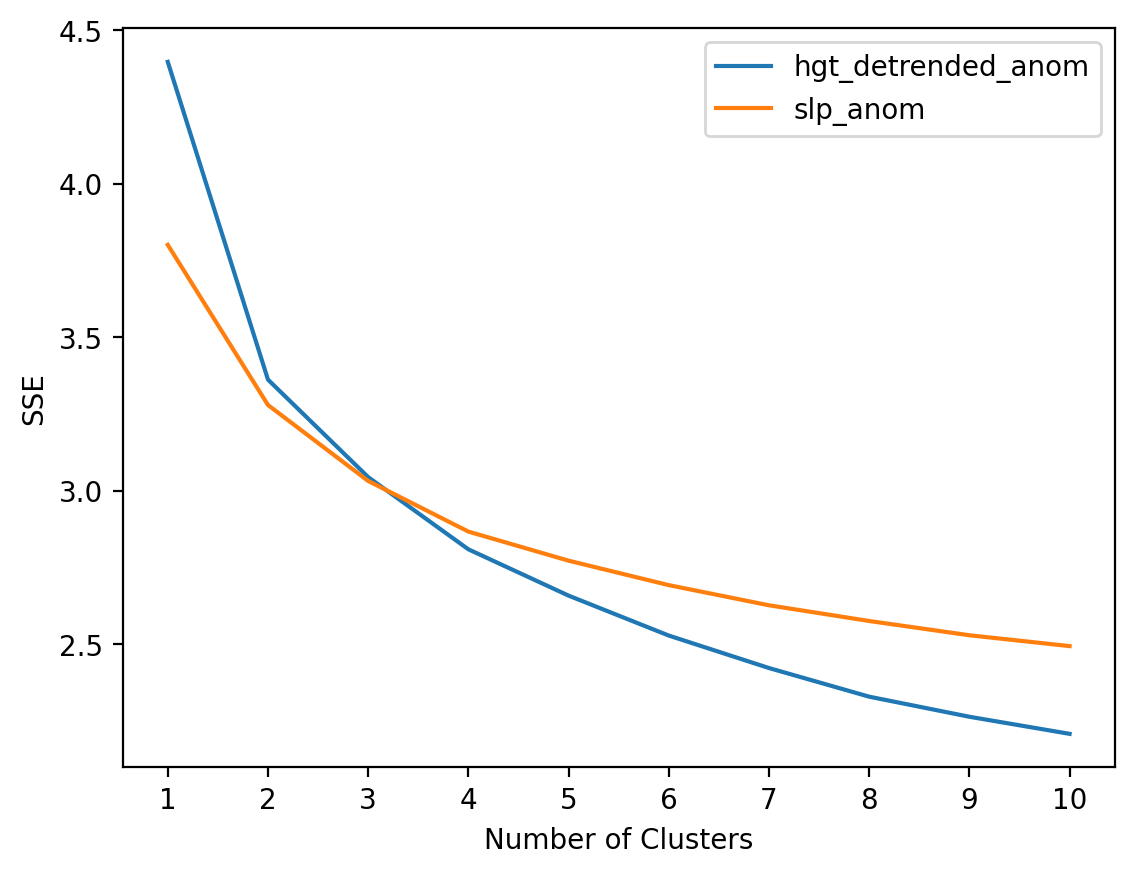

In [213]:
# Decide on number of clusters using elbow method
for feature in feature_ids: 
    da = lrp_epcp[feature]
    sse = []
    for k in range(1, 11):
        kmeans_fitted, _ = kmeans_xr(da, num_clusters=k)
        sse.append(kmeans_fitted.inertia_)

    plt.plot(range(1, 11), sse, label=feature)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.legend()

In [214]:
num_clusters = 3

### Make heatmaps of clusters for the LRP maps 

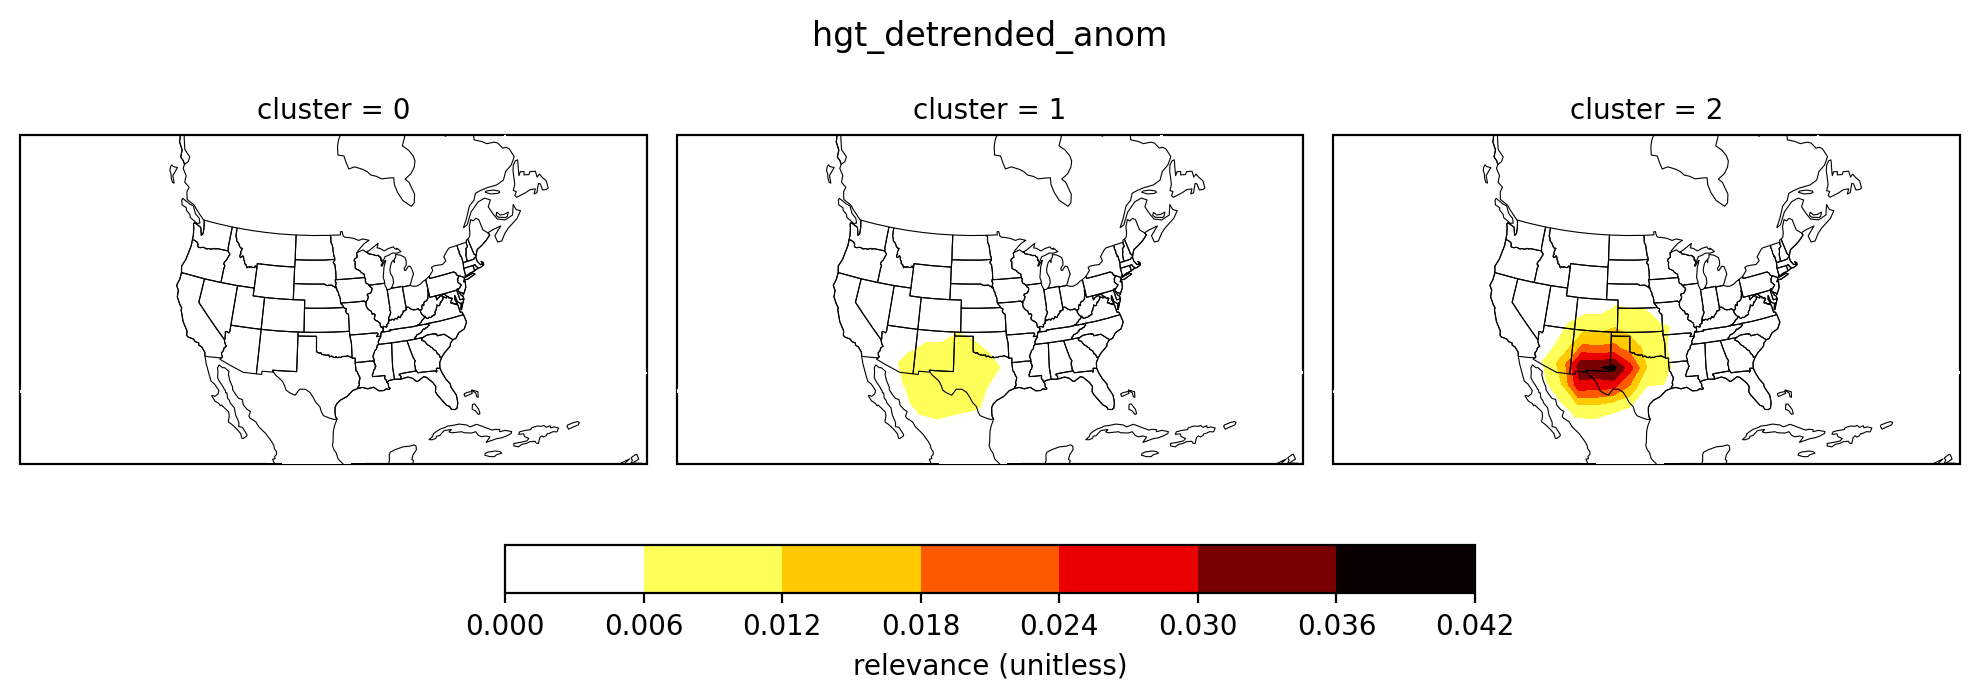

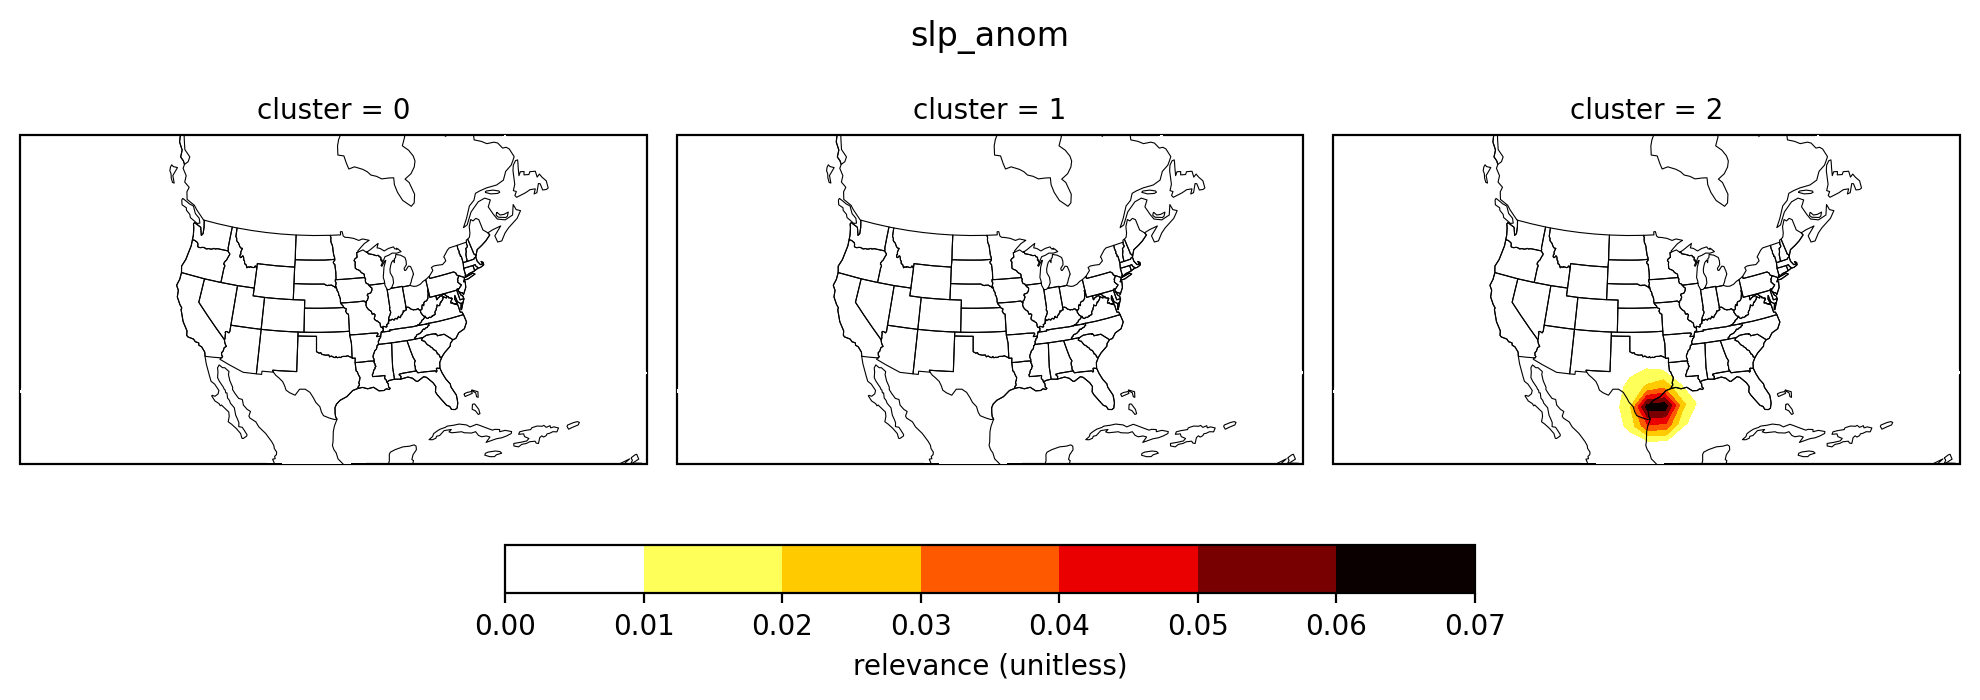

In [215]:
clusters_ds = lrp_epcp.apply(kmeans_clusters_xr, num_clusters=num_clusters)
for feature in feature_ids: 
    pl = make_heatmap(clusters_ds[feature], col="cluster")
    plt.suptitle(feature, y=1.06)

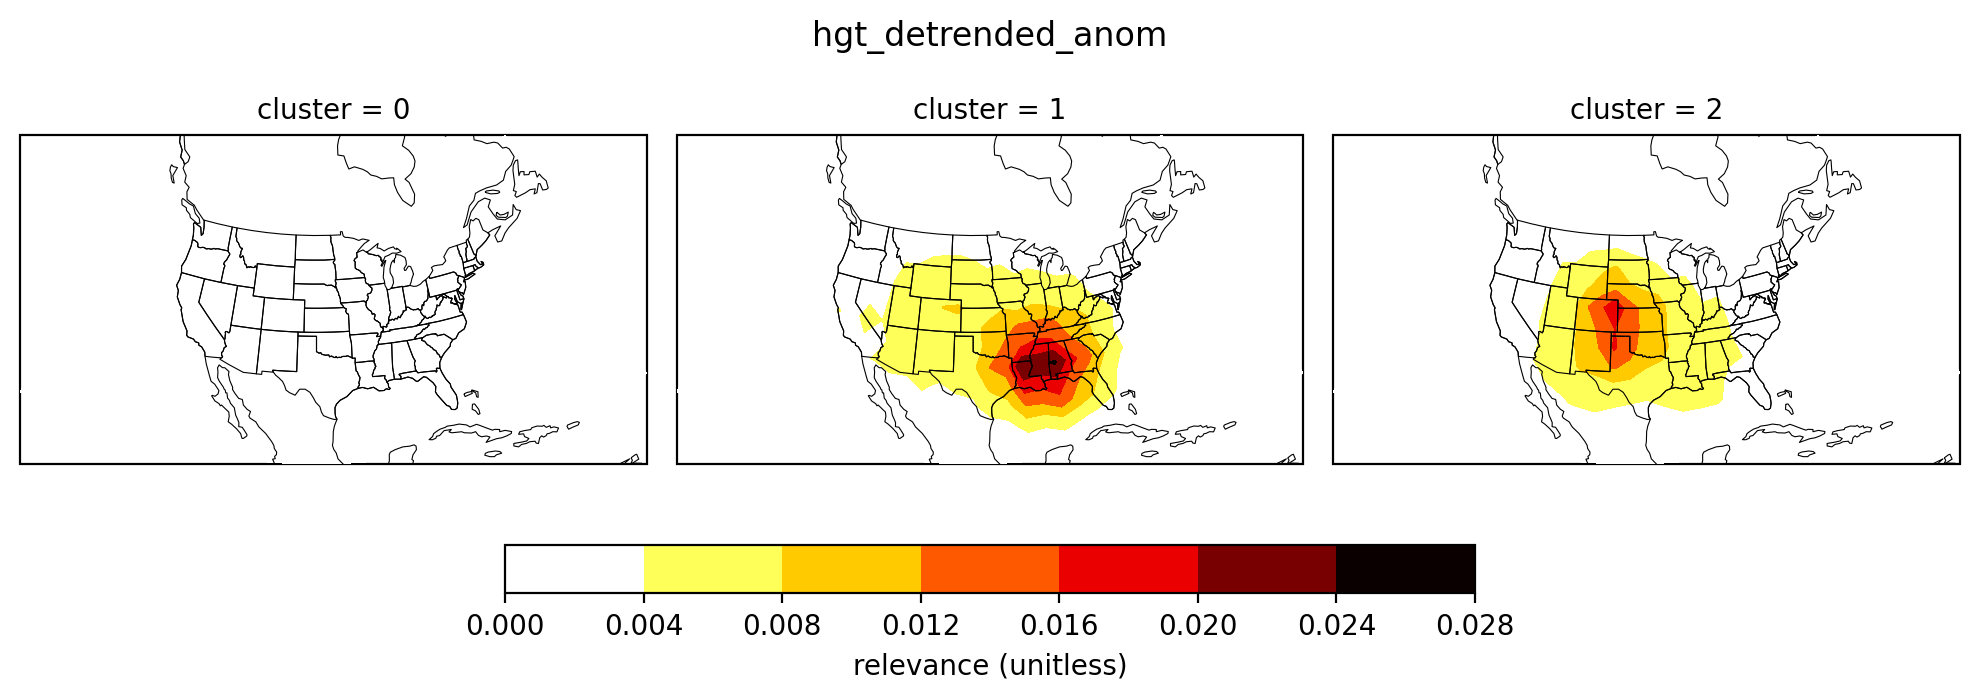

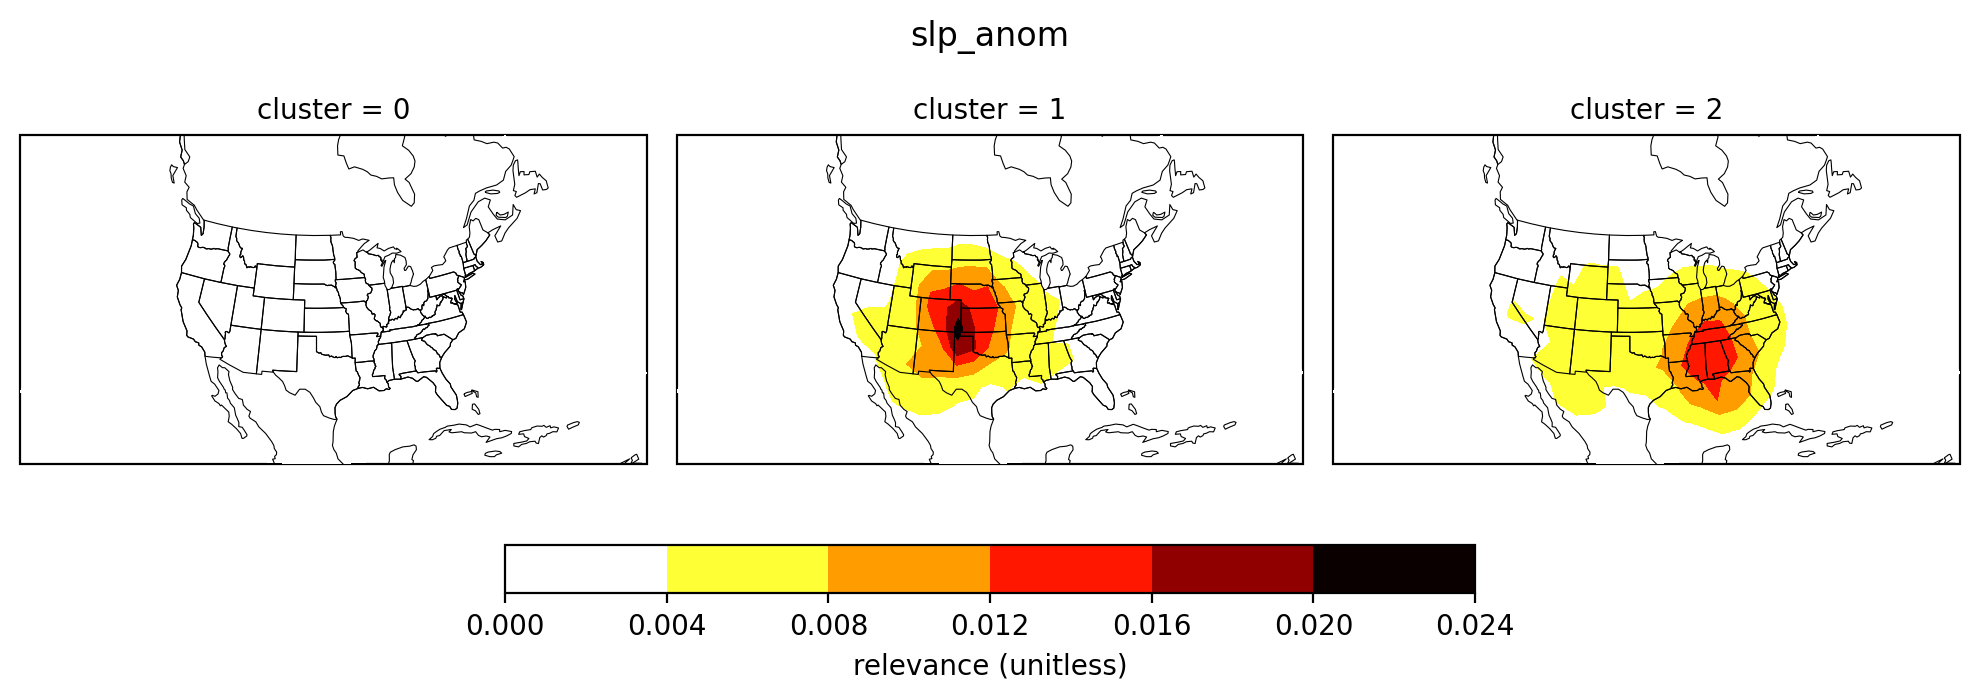

In [217]:
clusters_ds = lrp_no_epcp.apply(kmeans_clusters_xr, num_clusters=num_clusters)
for feature in feature_ids: 
    pl = make_heatmap(clusters_ds[feature], col="cluster")
    plt.suptitle(feature, y=1.06)